# NLP with Python: exploring Fate/Zero

Extracting information from texts can be useful in many ways, for example: finding main entities in texts, finding important information in a corpus, comparing texts, extracting main ideas, deducing author's writing style and many others things. Most of these tasks could be performed manually, but with spending condiderable amounts of time.

In this notebook I'll show how to do some of them with python.

For this task I use English translation of Japanese light novel "Fate/Zero", taken from this [site](https://www.baka-tsuki.org/project/index.php?title=Fate/Zero).

The story of Fate/Zero details the events of the Fourth Holy Grail War in Fuyuki City. The Holy Grail War is a contest, founded by the powerful magic families centuries ago, in which seven mages summon seven Heroic Spirits to compete to obtain the power of the "Holy Grail", which grants a wish to each member of the winning duo. After three inconclusive wars for the elusive Holy Grail, the Fourth War commences.

I downloaded the text and saved it in four files (one for each volume). Here is the content of the notebook:

1. [Data preparation](#datprep)
2. [Character occurence in text](#charocc)
3. [More information about characters](#detail)
4. [Common collocations](#coll)
5. [Wordcloud](#wcloud)

In [1]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.text import Text
from nltk.util import ngrams
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
en_stop = spacy.en.STOPWORDS
nlp = spacy.load('en')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
%matplotlib inline
from cycler import cycler

import re
import os
from scipy.misc import imread
from collections import Counter, defaultdict

## <a name='datprep'>Data Preparation</a>

In [2]:
#fate_folder = 'Data various/Fate_Zero/'
files = [os.path.join(fate_folder, f) for f in sorted(os.listdir(fate_folder)) if str(f).endswith('txt')]
files

['Data various/Fate_Zero/1.txt',
 'Data various/Fate_Zero/2.txt',
 'Data various/Fate_Zero/3.txt',
 'Data various/Fate_Zero/4.txt']

In [3]:
#Let's see how does the text looks like.
open(files[1], 'r', encoding='UTF-8').read()[:1000]

'\ufeffAct 5[edit]\n-150.39.43[edit]\n\nFurther removed to the west than Miyama town of Fuyuki, the winding state highway stretched westwards with its back towards the city\'s lights. Meanwhile, an undeveloped piece of forest waited for visitors further up the road. Continuing beyond even the prefectural border, the state highway silently meandered on.\n\nAlthough there were two lanes on the road, no crossing cars can be seen even with the sparse street lights. The state highway in the dead of night seemed to fade from memory and into the silence.\n\nIn such a silent night, a silver beast flew by.\n\nMercedes-Benz 300SL Coupe. The flowing, elegant, streamlined body with a scent of antiquity resembled a noble lady, while the roaring of the Inline-6 SOHC engine was like that of a fierce beast\'s. And behind the steering wheel of the classic sedan recklessly going beyond 100 kilometers per hour - were unexpectedly the slender wrists of a young lady.\n\n"Hey hey, this goes pretty fast, doe

There are some special unicode characters in the text(\ufeff), useless data (-150.39.43), technical words from the page ([edit]) and sentences are separated by "\n\n".

The following code reads each file, splits text into sentences and cleans the text. The result is a list of four lists with sentences.

In [4]:
def read_files():
    skillRegex = re.compile((r'-\d\d\d.\d\d.\d\d'))
    for f in files:
        temp_data = open(f, 'r', encoding='UTF-8').read()
        temp_data = [i for i in temp_data.split('\n')]
        temp_data = [i.replace(skillRegex.search(i).group(),'') if skillRegex.search(i) != None else i for i in temp_data]
        temp_data = [i.replace('[edit]', '').replace('\ufeff', '') for i in temp_data if i != '' and i != '[edit]']
        yield temp_data
text_sentences = list(read_files())
text_sentences[1][:10]

['Act 5',
 "Further removed to the west than Miyama town of Fuyuki, the winding state highway stretched westwards with its back towards the city's lights. Meanwhile, an undeveloped piece of forest waited for visitors further up the road. Continuing beyond even the prefectural border, the state highway silently meandered on.",
 'Although there were two lanes on the road, no crossing cars can be seen even with the sparse street lights. The state highway in the dead of night seemed to fade from memory and into the silence.',
 'In such a silent night, a silver beast flew by.',
 "Mercedes-Benz 300SL Coupe. The flowing, elegant, streamlined body with a scent of antiquity resembled a noble lady, while the roaring of the Inline-6 SOHC engine was like that of a fierce beast's. And behind the steering wheel of the classic sedan recklessly going beyond 100 kilometers per hour - were unexpectedly the slender wrists of a young lady.",
 '"Hey hey, this goes pretty fast, doesn\'t it?"',
 "Irisviel, w

In [5]:
#List of four lists with text.
text_lists = [' '.join(i) for i in text_sentences]
text_lists[1][:1000]

'Act 5 Further removed to the west than Miyama town of Fuyuki, the winding state highway stretched westwards with its back towards the city\'s lights. Meanwhile, an undeveloped piece of forest waited for visitors further up the road. Continuing beyond even the prefectural border, the state highway silently meandered on. Although there were two lanes on the road, no crossing cars can be seen even with the sparse street lights. The state highway in the dead of night seemed to fade from memory and into the silence. In such a silent night, a silver beast flew by. Mercedes-Benz 300SL Coupe. The flowing, elegant, streamlined body with a scent of antiquity resembled a noble lady, while the roaring of the Inline-6 SOHC engine was like that of a fierce beast\'s. And behind the steering wheel of the classic sedan recklessly going beyond 100 kilometers per hour - were unexpectedly the slender wrists of a young lady. "Hey hey, this goes pretty fast, doesn\'t it?" Irisviel, who held the steering wh

In [6]:
#One cleaned text.
text = ' '.join(text_lists)
text[:1000]

"Prologue 8 years ago Let us tell the story of a certain man. The tale of a man who, more than anyone else, believed in his ideals, and was driven to despair by them. The dream of that man was pure. His wish was for everyone in this world to be happy; that was all that he asked for. It is a childish ideal that all young boys grow attached to at least once, one that they abandon once they grow accustomed to the mercilessness of reality. Any happiness requires a sacrifice, something all children learn when they become adults. But, that man was different. Maybe he was just the most foolish of all. Maybe he was broken somewhere. Or maybe, he might have been of the kind we call 'Saints', entrusted with God's will. One that common people cannot understand. He knew that for any existence in this world, the only two alternatives are sacrifice, or salvation... After understanding that, he would never be able to empty the scale plates... From that day on, he set his mind to work on being the one

In [7]:
#I'll also need a tokenized text.
text_tokens_lists = []
tokenizer = RegexpTokenizer(r'\w+')
lemma = WordNetLemmatizer()
for j in text_lists:
    tokens = tokenizer.tokenize(j.lower())
    stopped_tokens = [i for i in tokens if i not in en_stop]
    lemmatized = [lemma.lemmatize(i) for i in stopped_tokens]
    text_tokens_lists.append(lemmatized)

text_tokens = [j for i in text_tokens_lists for j in i]

In [8]:
#Parse text with spacy
nlp_text = nlp(text)
#For nltk
text_nltk = Text(text_tokens)

## <a name='charocc'>Character occurence in text</a>

There are many ways to analyse text based on linguistics. But languages are complicated, often machine learning has lower accuracy than humans in correctly tagging the words.

For example let's try to find characters who are mentioned a lot in the text.

- At first I use spacy and try to find entities, who are considered to be persons;
- Then I find proper nouns, again with spacy;
- Next attempt is with nltk - finding various nouns;
- At last I simply find the most common words in the list of tokens;

In [9]:
def character_occurences(condition):
    if condition == 1:
        characters = Counter()
        for ent in nlp_text.ents:
            if ent.label_ == 'PERSON':
                characters[ent.lemma_] += 1
        return characters.most_common()
    
    if condition == 2:
        characters1 = Counter()
        for token in nlp_text:
            if token.pos_ == 'PROPN':
                characters1[token.lemma_] += 1
        return characters1.most_common()
    
    if condition == 3:
        tagged_tokens = nltk.pos_tag(text_tokens)
        characters2 = Counter()
        for token in tagged_tokens:
            if token[1] in ['NN', 'NNP', 'NNS']:
                characters2[token[0].lower()] += 1
        return characters2.most_common()
    
    else:
        counts = Counter(text_tokens)
        return counts.most_common()        

In [10]:
print('Spacy. Person entities.')
print(character_occurences(1)[:20])
print('\n', 'Spacy. Pronouns.')
print(character_occurences(2)[:20])
print('\n', 'NLTK.')
print(character_occurences(3)[:20])
print('\n', 'Counts.')
print(character_occurences(4)[:20])

Spacy. Person entities.
[('saber', 805), ('kiritsugu', 764), ('kirei', 618), ('waver', 343), ('irisviel', 319), ('archer', 292), ('kayneth', 273), ('kariya', 251), ('maiya', 189), ('tokiomi', 168), ('berserker', 150), ('emiya kiritsugu', 122), ('lancer', 99), ('ryūnosuke', 98), ('kotomine kirei', 94), ('caster', 93), ('assassin', 84), ('aoi', 72), ('tōsaka', 67), ('masters', 59)]

 Spacy. Pronouns.
[('saber', 1373), ('kiritsugu', 1276), ('’s', 1222), ('kirei', 976), ('irisviel', 721), ('waver', 658), ('grail', 553), ('tokiomi', 480), ('master', 447), ('lancer', 444), ('kariya', 404), ('rider', 391), ('kayneth', 367), ('holy', 364), ('servant', 345), ('archer', 337), ('maiya', 325), ('king', 305), ('tōsaka', 264), ('heroic', 254)]

 NLTK.
[('s', 1917), ('t', 1211), ('saber', 954), ('time', 944), ('kiritsugu', 879), ('kirei', 701), ('rider', 622), ('master', 605), ('hand', 589), ('man', 477), ('eye', 477), ('battle', 474), ('irisviel', 456), ('grail', 439), ('body', 410), ('heart', 409),

Well... it seems to be the case when there is no winner. Not in the best way. First attempt makes no mistakes(but there will be mistakes, of course, if I take more than 20 top words), but it seems that many occurences were missed due to incorrect tagging. Second attempt got more occurances, but there are some mistakes - like adjectives. NLTK is somewhere in between - more captured occurences and more wrong words.

NLP has a long way to go :)

Now I'll use the first attempt to visualize the frequency of characters' mentions.

In [11]:
def offsets(text):
    '''
    Collect positions of words in text.
    '''
    offsets = defaultdict(list)
    for ent in text.ents:
        if ent.label_ == 'PERSON':
            offsets[ent.lemma_].append(ent.start)
            
    return dict(offsets)

occurences = offsets(nlp_text)

def plot_character(labels):
    x = [occurences[label] for label in labels] 
    plt.figure(figsize=(16,12))
    bins_n = 20
    n, bins, patches = plt.hist(x, bins_n, label=labels)
    plt.clf()
    ax = plt.subplot(111)
    for i, a in enumerate(n):
        ax.plot([float(x) / (bins_n - 1) for x in range(len(a))], a, label=labels[i])

    matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['r', 'b', 'y', 'black', 'cyan', 'green', 'lightgray'])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #Divide plot into chapters. It isn't exact, but should be accurate enough.
    labels = [0, 0, 'Act 1', 'Act 2', 'Act 3', 'Act 4', 'Act 5', 'Act 6', 'Act 7', 'Act 8', 'Act 9', 'Act 10', 'Act 11',
              'Act 12', 'Act 13', 'Act 14', 'Act 15', 'Act 16', 'Act 17', 'Act 18', 'Epilogue']
    ax.set_xticklabels(labels)
    tick_spacing = 0.05
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

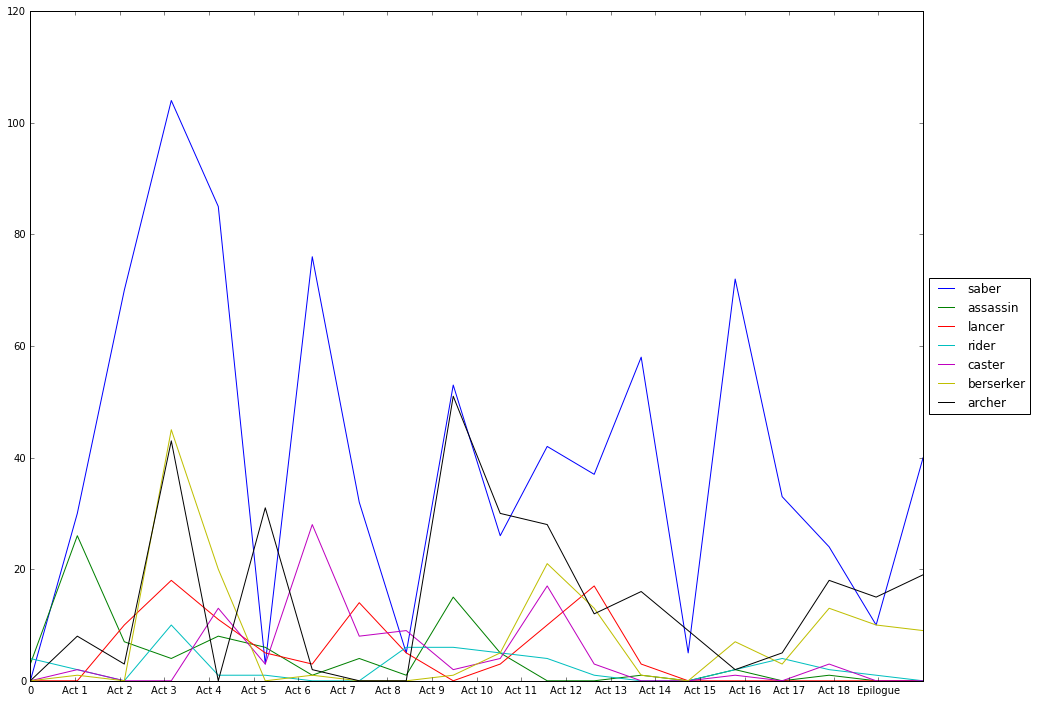

In [12]:
#Occurences of servants.
plot_character(['saber', 'assassin', 'lancer', 'rider', 'caster', 'berserker', 'archer'])

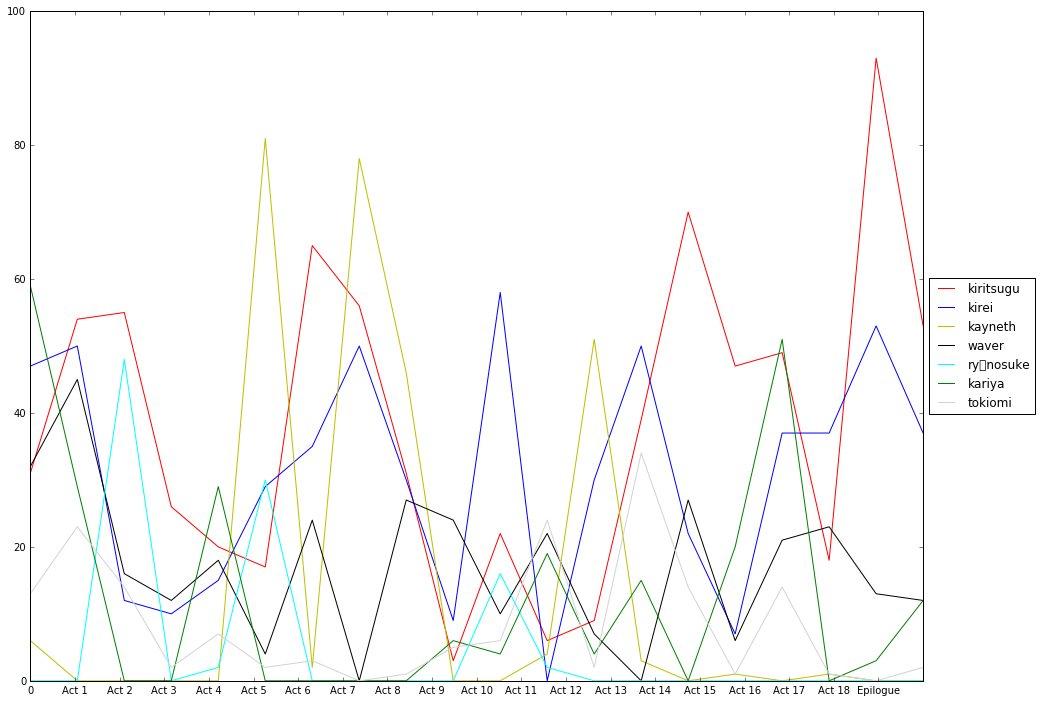

In [13]:
#Occurences of masters.
plot_character(['kiritsugu', 'kirei', 'kayneth', 'waver', 'ryūnosuke', 'kariya', 'tokiomi'])

These plots show how often the characters were mentioned in the story. They could be improved, of course: characters could be adressed in a variety of ways, so a good idea would be to find all the ways the characters were adressed, group them and plot.

But nevertheless this plot shows general information: most active characters, parts of the story in which certain characters were most active and, of course, characters who died at some point and stopped being mentioned.

NLTK offers a possibility to draw a dispersion plot for chosen tokens, but it is very basic.

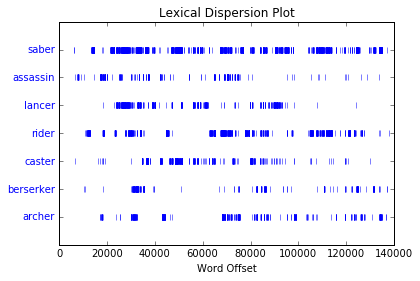

In [14]:
text_nltk.dispersion_plot(['saber', 'assassin', 'lancer', 'rider', 'caster', 'berserker', 'archer'])

## <a name='detail'>More information about characters</a>

It is possible to parse text and find relationships between words. For example, one could find adjectives, describing certain character.

In [15]:
def get_adjectives(doc, character_lemma):
    adjectives = []
    for ent in nlp_text.ents:
        if ent.lemma_ == character_lemma:
            for token in ent.subtree:
                if token.dep_ == 'amod':
                    adjectives.append(token.lemma_)
    
    for ent in nlp_text.ents:
        if ent.lemma_ == character_lemma:
            if ent.root.dep_ == 'nsubj':
                for child in ent.root.head.children:
                    if child.dep_ == 'acomp':
                        adjectives.append(child.lemma_)
    
    return adjectives

With this we can know general characterictics of the character. It is possible to extract adjectives for a character in each chapter/volume to see whether the characters mood changed in the story.

In [16]:
print(get_adjectives(nlp_text, 'waver'))

['good', 'defiant', 'puzzled', 'stern', 'mediocre', 'calm', 'rightful', 'waver', 'bloodthirsty', 'small', 'last', 'tense', 'interested', 'cautious', 'exalted', 'short', 'relieved', 'dizzy', 'convinced', 'pissed', 'aware', 'agitated', 'able', 'capable', 'superior', 'grateful', 'helpless', 'silent', 'unhappy', 'astonished', 'glad', 'different', 'uncomfortable', 'unused', 'eager', 'reluctant', 'worried', 'nauseous', 'mature', 'aware', 'oblivious', 'happy', 'alone', 'alone', 'able']


We can also find most used words belonging to separate parts of speach.

In [17]:
tag_list = ['PROPN', 'ADJ', 'ADP', 'PRON', 'ADV', 'NOUN', 'VERB']
for i in tag_list:
    words = [token.lemma_ for token in nlp_text if token.pos_ == i and token.lemma_ not in en_stop]
    words_count = Counter(words)
    print(i, words_count.most_common(10))

PROPN [('saber', 1373), ('kiritsugu', 1276), ('’s', 1222), ('kirei', 976), ('irisviel', 721), ('waver', 658), ('grail', 553), ('tokiomi', 480), ('master', 447), ('lancer', 444)]
ADJ [('’s', 343), ('right', 268), ('great', 207), ('able', 204), ('black', 189), ('true', 189), ('long', 157), ('old', 156), ('different', 149), ('good', 131)]
ADP [('like', 839), ('inside', 63), ('outside', 60), ('despite', 54), ('till', 38), ('beneath', 33), ('near', 27), ('past', 23), ('whilst', 20), ('unlike', 14)]
PRON [('you’re', 23), ('’s', 20), ("'s", 17), ('you…', 13), ('i’ll', 10), ('i’ve', 7), ('–', 5), ('you’ve', 5), ('oneself', 5), ('you’ll', 5)]
ADV [('completely', 277), ('away', 227), ('definitely', 217), ('matter', 199), ('finally', 197), ('suddenly', 186), ('right', 178), ('long', 162), ('far', 156), ('probably', 152)]
NOUN [('time', 915), ('hand', 574), ('man', 526), ('eye', 471), ('battle', 459), ('body', 413), ('heart', 407), ('thing', 393), ('word', 338), ('world', 336)]
VERB [('know', 514)

One more interesting idea is to find characters, who are described by the same thing. This could be an adjective, verb, or something else.

In [18]:
counter = Counter()
word_list = ['say', 'tell', 'speak']

for ent in nlp_text.ents:
    if ent.label_ == 'PERSON' and ent.root.head.lemma_ in word_list:
        counter[ent.text] += 1

print(counter.most_common(30)) 

[('Kirei', 17), ('Saber', 16), ('Tokiomi', 9), ('Irisviel', 9), ('Waver', 8), ('Archer', 8), ('Kiritsugu', 8), ('Kayneth', 7), ('Maiya', 5), ('Shirley', 4), ('Rin', 2), ('Glen', 2), ('Kotomine Kirei', 2), ('Bluebeard', 2), ('Ryūnosuke', 2), ('Natalia', 2), ('Sola', 2), ('we’ve', 1), ('Gilgamesh', 1), ('Hisau Maiya… Irisviel', 1), ('Mother', 1), ('Emiya Kiritsugu', 1), ('Lancer', 1), ('Zōken', 1), ('Sabbāh', 1), ('Natalie', 1), ('Ilya', 1), ('Irisviel von Einsbern', 1), ('Grandfather', 1), ('Alexander', 1)]


It could seem that characters don't speak a lot. But this is due to the nature of the text - words, describing an action of saying something, are seldom used.

## <a name='coll'>Common collocations</a>

One of the ways to find out an unique style of the text is looking for collocatins. I divide the text into phrases of two or more words to see which of the most common ones are unique to this text.

In [19]:
n_grams = ngrams(text_tokens,2)
Counter(n_grams).most_common(20)

[(('saber', 's'), 312),
 (('holy', 'grail'), 307),
 (('heroic', 'spirit'), 281),
 (('kiritsugu', 's'), 250),
 (('noble', 'phantasm'), 232),
 (('emiya', 'kiritsugu'), 193),
 (('couldn', 't'), 190),
 (('command', 'seal'), 189),
 (('kirei', 's'), 175),
 (('wasn', 't'), 167),
 (('rider', 's'), 165),
 (('heaven', 's'), 153),
 (('isn', 't'), 152),
 (('s', 'feel'), 150),
 (('kotomine', 'kirei'), 148),
 (('waver', 's'), 123),
 (('king', 'conqueror'), 123),
 (('lancer', 's'), 120),
 (('irisviel', 's'), 115),
 (('tokiomi', 's'), 112)]

Common phrases include character names or termins from the story.

In [20]:
n_grams = ngrams(text_tokens,3)
Counter(n_grams).most_common(20)

[(('heaven', 's', 'feel'), 150),
 (('holy', 'grail', 'war'), 40),
 (('couldn', 't', 'help'), 40),
 (('lord', 'el', 'melloi'), 39),
 (('s', 'noble', 'phantasm'), 36),
 (('war', 'holy', 'grail'), 36),
 (('kotomine', 'kirei', 's'), 29),
 (('emiya', 'kiritsugu', 's'), 28),
 (('lancer', 's', 'master'), 25),
 (('long', 'time', 'ago'), 22),
 (('tōsaka', 'tokiomi', 's'), 20),
 (('kayneth', 'el', 'melloi'), 17),
 (('s', 'right', 'hand'), 17),
 (('waver', 'couldn', 't'), 15),
 (('el', 'melloi', 's'), 14),
 (('use', 'command', 'seal'), 13),
 (('saber', 's', 'master'), 13),
 (('t', 'help', 'feel'), 13),
 (('kariya', 's', 'body'), 13),
 (('fourth', 'heaven', 's'), 13)]

In [21]:
n_grams = ngrams(text_tokens,4)
Counter(n_grams).most_common(20)

[(('couldn', 't', 'help', 'feel'), 13),
 (('fourth', 'heaven', 's', 'feel'), 13),
 (('lord', 'el', 'melloi', 's'), 10),
 (('kayneth', 'el', 'melloi', 'archibald'), 9),
 (('saber', 's', 'noble', 'phantasm'), 9),
 (('saber', 's', 'left', 'hand'), 9),
 (('anti', 'fortress', 'noble', 'phantasm'), 9),
 (('sola', 'ui', 'nuada', 'sophia'), 7),
 (('ui', 'nuada', 'sophia', 'ri'), 7),
 (('command', 'seal', 'right', 'hand'), 6),
 (('rider', 's', 'noble', 'phantasm'), 6),
 (('participating', 'heaven', 's', 'feel'), 6),
 (('waver', 'couldn', 't', 'help'), 5),
 (('short', 'spear', 'left', 'hand'), 5),
 (('archer', 's', 'noble', 'phantasm'), 5),
 (('kiritsugu', 's', 'right', 'hand'), 5),
 (('irisviel', 'couldn', 't', 'help'), 5),
 (('previous', 'heaven', 's', 'feel'), 4),
 (('lancer', 's', 'red', 'spear'), 4),
 (('bastard', 'bastard', 'bastard', 'bastard'), 4)]

But the more words are in the phrase, the more probable it is that is was a coincidence. Bi- and trigrams are usually the most interesting.

## <a name='wcloud'>Wordcloud</a>

Wordclouds provide a great way of showing topics or most important words in the text.

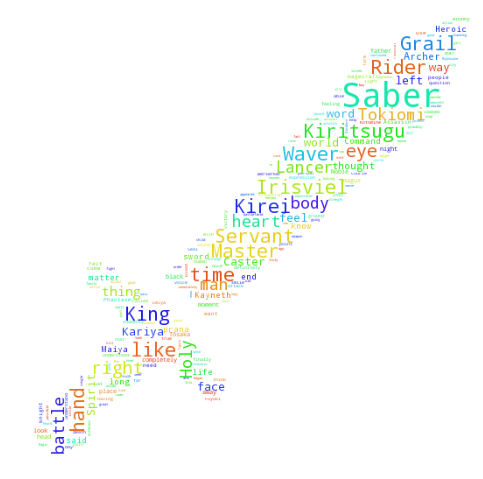

In [22]:
#The source of the icon: http://icons.iconarchive.com/icons/icons8/windows-8/512/Military-Sword-icon.png
mask_ = imread('Data various/Fate_Zero/sword.png', flatten=False)
wordcloud = WordCloud(max_font_size=None, mask=mask_, stopwords=en_stop, background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Conclusion

In this notebook I showed some of the ways to extract information from texts. NLP and machine learning allow ot get a gist of a story, to describe the events and many other things. A more advanced idea is to automatically summarize texts, but this will be adressed in another notebook.